# Relationships using genome distance vs expression distance

In our attempt to label modules as "mostly core", "mostly accessory" or "mixed". We found that most modules were "mixed" and some were "mostly accessory". We noticed that there were many modules that had only core genes, yet were not found to be signficanlty "mostly core" based on our Fisher's exact test due to the small size of the modules as well as the large imbalance in the number of core:accessory genes.

These small modules, which are due to operons, is biologically sensible but hard for us to apply statistics. We want to try to tease apart the co-expression relationships that are due to locations (i.e. being in the same operon) versus other functional reasons.

Our strategy is the following:
* For each accessory gene, is the 1-NN/2-NN/3-NN core or accessory? Same for core genes
* For each accessory gene, is the highest correlated/2nd-highest correlated/3rd highest correlated gene core or accessory? Same for core genes.

Then we can compare the trends seen in both

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import random
import scipy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import multipletests
from core_acc_modules import utils, paths

random.seed(1)

/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
# User params
method = "affinity"
offset_to_bin = 10

### Import module memberships

In [3]:
# Import module memberships
pao1_membership_filename = os.path.join(
    paths.LOCAL_DATA_DIR, f"pao1_modules_{method}.tsv"
)
pa14_membership_filename = os.path.join(
    paths.LOCAL_DATA_DIR, f"pa14_modules_{method}.tsv"
)

pao1_membership = pd.read_csv(pao1_membership_filename, sep="\t", index_col=0, header=0)
pa14_membership = pd.read_csv(pa14_membership_filename, sep="\t", index_col=0, header=0)

In [4]:
pao1_membership.head()

,module id
PA0001,415
PA0002,573
PA0003,92
PA0004,567
PA0005,0


In [5]:
pa14_membership.head()

,module id
PA14_55610,3
PA14_55600,16
PA14_55590,602
PA14_55580,431
PA14_55570,46


### Import and format operon data

In [6]:
pao1_operon_filename = paths.PAO1_OPERON
pa14_operon_filename = paths.PA14_OPERON

In [7]:
pao1_operon = pd.read_csv(pao1_operon_filename, index_col=0, header=0)
pa14_operon = pd.read_csv(pa14_operon_filename, index_col=0, header=0)

In [8]:
pao1_operon.head()

,operon_name,locus_tag,start,end,strand,gene_name,source_database,pmid
operon-id,,,,,,,,
operon-1,dnaA-dnaN-recF-gyrB,PA0001,483,2027,1,dnaA,DOOR,18988623
operon-1,dnaA-dnaN-recF-gyrB,PA0002,2056,3159,1,dnaN,DOOR,18988623
operon-1,dnaA-dnaN-recF-gyrB,PA0003,3169,4278,1,recF,DOOR,18988623
operon-1,dnaA-dnaN-recF-gyrB,PA0004,4275,6695,1,gyrB,DOOR,18988623
operon-2,PA0006-lptA,PA0005,7018,7791,-1,lptA,DOOR,18988623


In [9]:
pao1_operon = pao1_operon.set_index("locus_tag")
pa14_operon = pa14_operon.set_index("locus_tag")

In [10]:
print(pao1_operon.shape)
pao1_operon.head()

(3816, 7)


,operon_name,start,end,strand,gene_name,source_database,pmid
locus_tag,,,,,,,
PA0001,dnaA-dnaN-recF-gyrB,483,2027,1,dnaA,DOOR,18988623
PA0002,dnaA-dnaN-recF-gyrB,2056,3159,1,dnaN,DOOR,18988623
PA0003,dnaA-dnaN-recF-gyrB,3169,4278,1,recF,DOOR,18988623
PA0004,dnaA-dnaN-recF-gyrB,4275,6695,1,gyrB,DOOR,18988623
PA0005,PA0006-lptA,7018,7791,-1,lptA,DOOR,18988623


In [11]:
# There are 247 PAO1 genes with multiple annotations
# This operon df contains annotations from predicted operons based on DOOR database
# predictions which make up the majority of the operons) as well as some that
# are curated (i.e. PseudoCAP)
# There are some that have multiple PseudoCAP annotations too

# Here we will keep the last PseudoCAP annotations
# Note: Do we want to discard these annotations all together
# or will these need to be carefully curated to determine which to keep?
# We will use the curated annotation here
pao1_operon = pao1_operon[~pao1_operon.index.duplicated(keep="last")]
pa14_operon = pa14_operon[~pa14_operon.index.duplicated(keep="last")]

In [12]:
pao1_operon.head()

,operon_name,start,end,strand,gene_name,source_database,pmid
locus_tag,,,,,,,
PA0001,dnaA-dnaN-recF-gyrB,483,2027,1,dnaA,DOOR,18988623
PA0002,dnaA-dnaN-recF-gyrB,2056,3159,1,dnaN,DOOR,18988623
PA0003,dnaA-dnaN-recF-gyrB,3169,4278,1,recF,DOOR,18988623
PA0004,dnaA-dnaN-recF-gyrB,4275,6695,1,gyrB,DOOR,18988623
PA0005,PA0006-lptA,7018,7791,-1,lptA,DOOR,18988623


In [13]:
# Only include columns for gene id and operon_name
pao1_operon = pao1_operon["operon_name"].to_frame()
pa14_operon = pa14_operon["operon_name"].to_frame()

In [14]:
print(pao1_operon.shape)
pao1_operon.head()

(3569, 1)


,operon_name
locus_tag,
PA0001,dnaA-dnaN-recF-gyrB
PA0002,dnaA-dnaN-recF-gyrB
PA0003,dnaA-dnaN-recF-gyrB
PA0004,dnaA-dnaN-recF-gyrB
PA0005,PA0006-lptA


### Map core/accessory labels to genes

In [15]:
# Read in expression data
pao1_expression_filename = paths.PAO1_COMPENDIUM
pa14_expression_filename = paths.PA14_COMPENDIUM

pao1_expression = pd.read_csv(pao1_expression_filename, sep="\t", index_col=0, header=0)
pa14_expression = pd.read_csv(pa14_expression_filename, sep="\t", index_col=0, header=0)

In [16]:
pao1_annot_filename = paths.GENE_PAO1_ANNOT
pa14_annot_filename = paths.GENE_PA14_ANNOT

core_acc_dict = utils.get_my_core_acc_genes(
    pao1_annot_filename, pa14_annot_filename, pao1_expression, pa14_expression
)

Number of PAO1 core genes: 5366
Number of PA14 core genes: 5363
Number of PAO1 core genes in my dataset: 5361
Number of PA14 core genes in my dataset: 5357
Number of PAO1-specific genes: 202
Number of PA14-specific genes: 534


In [17]:
pao1_core = core_acc_dict["core_pao1"]
pa14_core = core_acc_dict["core_pa14"]
pao1_acc = core_acc_dict["acc_pao1"]
pa14_acc = core_acc_dict["acc_pa14"]

In [18]:
pao1_membership.loc[pao1_core, "core/acc"] = "core"
pao1_membership.loc[pao1_acc, "core/acc"] = "acc"

In [19]:
# pa14_acc_shared = set(pa14_acc).intersection(pa14_gene_module_labels.index)
pa14_membership.loc[pa14_core, "core/acc"] = "core"
pa14_membership.loc[pa14_acc, "core/acc"] = "acc"

In [20]:
# Drop "module id" column
pao1_arr = pao1_membership.drop("module id", axis=1)
pa14_arr = pa14_membership.drop("module id", axis=1)

In [21]:
# Make sure to sort by gene id
# NOTE PA14 gene ids don't increment by 1, but by 10 or 20 are we missing some genes?
pao1_arr = pao1_arr.sort_index()
pa14_arr = pa14_arr.sort_index()

In [22]:
print(pao1_arr.shape)
pao1_arr.head()

(5563, 1)


,core/acc
PA0001,core
PA0002,core
PA0003,core
PA0004,core
PA0005,core


In [23]:
pao1_arr.tail()

,core/acc
PA5566,core
PA5567,core
PA5568,core
PA5569,core
PA5570,acc


In [24]:
print(pa14_arr.shape)
pa14_arr.head()

(5891, 1)


,core/acc
PA0263.1,acc
PA0263.2,acc
PA0263.3,acc
PA14_00010,core
PA14_00020,core


In [25]:
pa14_arr.tail()

,core/acc
PA14_73390,core
PA14_73400,core
PA14_73410,core
PA14_73420,core
PA2170.1,acc


In [26]:
# Fill in index of operon_df to include all genes
all_pao1_gene_ids = pao1_arr.index
all_pa14_gene_ids = pa14_arr.index

# Get missing gene ids
missing_pao1_gene_ids = set(all_pao1_gene_ids).difference(pao1_operon.index)
missing_pa14_gene_ids = set(all_pa14_gene_ids).difference(pa14_operon.index)

# Make dataframe with missing gene ids with np.nan values for operon_name
missing_pao1_gene_df = pd.DataFrame(
    data=np.nan, index=list(missing_pao1_gene_ids), columns=["operon_name"]
)
missing_pa14_gene_df = pd.DataFrame(
    data=np.nan, index=list(missing_pa14_gene_ids), columns=["operon_name"]
)

pao1_operon_genome_dist = pao1_operon.append(missing_pao1_gene_df)
pa14_operon_genome_dist = pa14_operon.append(missing_pa14_gene_df)

pao1_operon_genome_dist = pao1_operon_genome_dist.loc[all_pao1_gene_ids]
pa14_operon_genome_dist = pa14_operon_genome_dist.loc[all_pa14_gene_ids]

In [27]:
print(pao1_operon_genome_dist.shape)
pao1_operon_genome_dist.tail()

(5563, 1)


,operon_name
PA5566,NaN
PA5567,PA5568-PA5567
PA5568,PA5568-PA5567
PA5569,rpmH-rnpA
PA5570,rpmH-rnpA


In [28]:
print(pa14_operon_genome_dist.shape)
pa14_operon_genome_dist.tail()

(5891, 1)


,operon_name
PA14_73390,NaN
PA14_73400,PA14_73410-trmE
PA14_73410,PA14_73410-trmE
PA14_73420,NaN
PA2170.1,NaN


## Find relationships using genome distance

In [29]:
def get_relationship_in_genome_space(core_acc_df, offset_to_bin, operon_df=None):
    gene_type_start = ["acc", "core"]
    gene_type_compare = ["acc", "core"]

    core_acc_df_len = len(core_acc_df)
    offset_max = core_acc_df_len - 1

    core_acc_df_pad = np.pad(
        core_acc_df["core/acc"], offset_max, "constant", constant_values="NA"
    )

    if operon_df is not None:
        operon_df_pad = np.pad(
            operon_df["operon_name"], offset_max, "constant", constant_values="NA"
        )

        assert core_acc_df.shape == operon_df.shape

    rows = []

    for gene_start in gene_type_start:
        for gene_compare in gene_type_compare:
            for offset in range(1, offset_max + 1):
                # Print statements to understand what is happening
                # print("start left", core_acc_df_pad[offset_max : core_acc_df_len + offset_max])
                # print("compare left", core_acc_df_pad[
                #             offset_max - offset : core_acc_df_len + offset_max - offset
                #         ])
                #
                # print("start left", operon_df_pad[offset_max : core_acc_df_len + offset_max])
                # print("compare left", operon_df_pad[
                #             offset_max - offset : core_acc_df_len + offset_max - offset
                #         ])

                # Compare left nearest neighbors: Are they core or accessory?
                core_acc_left = (
                    core_acc_df_pad[offset_max : core_acc_df_len + offset_max]
                    == gene_start
                ) & (
                    core_acc_df_pad[
                        offset_max - offset : core_acc_df_len + offset_max - offset
                    ]
                    == gene_compare
                )

                # Compare right nearest neighbors: Are they core or accessory?
                core_acc_right = (
                    core_acc_df_pad[offset_max : core_acc_df_len + offset_max]
                    == gene_start
                ) & (
                    core_acc_df_pad[
                        offset_max + offset : core_acc_df_len + offset_max + offset
                    ]
                    == gene_compare
                )

                if operon_df is not None:
                    # Compare left operons: Are the genes in the same operon?
                    operon_left = (
                        operon_df_pad[offset_max : core_acc_df_len + offset_max]
                        == operon_df_pad[
                            offset_max - offset : core_acc_df_len + offset_max - offset
                        ]
                    )

                    # Compare right operons: Are the genes in the same operon?
                    operon_right = (
                        operon_df_pad[offset_max : core_acc_df_len + offset_max]
                        == operon_df_pad[
                            offset_max + offset : core_acc_df_len + offset_max + offset
                        ]
                    )

                    # Sum all comparisons
                    counts = (core_acc_left & ~operon_left).sum() + (
                        core_acc_right & ~operon_right
                    ).sum()
                else:
                    counts = core_aff_left.sum() + core_acc_right.sum()

                rows.append(
                    {
                        "gene start": gene_start,
                        "gene compare": gene_compare,
                        "offset": offset,
                        "total": counts,
                    }
                )

    genome_dist_counts = pd.DataFrame(rows)

    # Bin distances above offset_to_bin
    long_dist = (
        genome_dist_counts.query("offset>@offset_to_bin")
        .groupby(["gene compare", "gene start"])["total"]
        .mean()
        .reset_index()
    )
    long_dist["offset"] = f"{offset_to_bin}+"
    genome_dist_counts = genome_dist_counts.query("offset<=@offset_to_bin").append(
        long_dist, ignore_index=True
    )

    return genome_dist_counts

In [30]:
genome_dist_counts_pao1 = get_relationship_in_genome_space(
    pao1_arr, offset_to_bin, pao1_operon_genome_dist
)
genome_dist_counts_pa14 = get_relationship_in_genome_space(
    pa14_arr, offset_to_bin, pa14_operon_genome_dist
)

In [31]:
genome_dist_counts_pao1.head()

,gene start,gene compare,offset,total
0,acc,acc,1,108.0
1,acc,acc,2,128.0
2,acc,acc,3,110.0
3,acc,acc,4,102.0
4,acc,acc,5,84.0


In [32]:
genome_dist_counts_pa14.head()

,gene start,gene compare,offset,total
0,acc,acc,1,378.0
1,acc,acc,2,486.0
2,acc,acc,3,496.0
3,acc,acc,4,490.0
4,acc,acc,5,472.0


## Find relationships using expression distance

In [33]:
# Correlation matrix files
pao1_corr_filename = paths.PAO1_CORR_LOG_SPELL
pa14_corr_filename = paths.PA14_CORR_LOG_SPELL

In [34]:
# Load correlation data
pao1_corr = pd.read_csv(pao1_corr_filename, sep="\t", index_col=0, header=0)
pa14_corr = pd.read_csv(pa14_corr_filename, sep="\t", index_col=0, header=0)

In [35]:
def get_relationship_in_expression_space(
    corr_df,
    genes_to_consider,
    gene_mapping_df,
    offset_to_bin,
    operon_df=None,
    sum_increment=1,
):
    # Get subset of genes
    corr_subset = corr_df.loc[genes_to_consider]

    rows = []
    for gene in corr_subset.index:

        if operon_df is not None:
            # This subset needs to be reset each iteration
            # since we are dropping columns below
            corr_subset = corr_df.loc[genes_to_consider]

            # Check if gene is found in an operon
            if gene in operon_df.index:
                # Find operons containing 'gene'
                group_name = operon_df.loc[gene, "operon_name"]

                # Dictionary format: pao1_operon_dict[operon_name] = [list of genes]
                operon_dict = operon_df.groupby("operon_name").groups
                co_operonic_genes = list(operon_dict[group_name])

                # Remove columns corresponding to co-operonic genes from the corr_subset
                co_operonic_genes_to_remove = list(
                    set(corr_subset.columns).intersection(co_operonic_genes)
                )
                corr_subset = corr_subset.drop(columns=co_operonic_genes_to_remove)

        offset_max = corr_subset.shape[1]

        top_corr_genes = list(corr_subset.loc[gene].nlargest(offset_max).index[1:])
        top_gene_labels = list(gene_mapping_df.loc[top_corr_genes, "core/acc"].values)
        rows.append(top_gene_labels)

    expression_dist_counts = pd.DataFrame(rows)

    # Count types of relationships
    expression_dist_counts_acc = (expression_dist_counts == "acc").sum().to_frame("acc")

    expression_dist_counts = expression_dist_counts_acc.join(
        (expression_dist_counts == "core").sum().to_frame("core")
    )
    if sum_increment > 1:
        expression_dist_counts = (
            expression_dist_counts.rolling(sum_increment)
            .sum()
            .iloc[::-1]
            .shift(1)
            .sort_index()
        )

    # Format counts for plotting
    expression_dist_counts = expression_dist_counts.melt(
        var_name="gene type", value_name="total", ignore_index=False
    )
    expression_dist_counts = expression_dist_counts.rename_axis("offset").reset_index()
    expression_dist_counts["offset"] = expression_dist_counts["offset"] + 1

    # Average counts for weaker correlation relationships
    weak_corr = (
        expression_dist_counts.query("offset>@offset_to_bin")
        .groupby("gene type")["total"]
        .mean()
        .to_frame()
    )
    weak_corr = weak_corr.reset_index()
    weak_corr["offset"] = f"+{offset_to_bin}"

    expression_dist_counts = expression_dist_counts.query(
        "offset<=@offset_to_bin"
    ).append(weak_corr, ignore_index=True)

    # Add proportion - How should we calculate proportion
    # Of all 1-NN, %accessory, %core
    # Or, of all the accessory genes, %are 1-NN, of all core genes, %are 1-NN
    # total_counts = expression_dist_counts.groupby("offset")["total"].sum()[1]
    # expression_dist_counts["proportion"] = expression_dist_counts["total"]/total_counts

    return expression_dist_counts

In [36]:
%%time
expression_dist_counts_pao1_acc = get_relationship_in_expression_space(
    pao1_corr, pao1_acc, pao1_arr, offset_to_bin, pao1_operon
)
expression_dist_counts_pao1_core = get_relationship_in_expression_space(
    pao1_corr, pao1_core, pao1_arr, offset_to_bin, pao1_operon
)

CPU times: user 7min 12s, sys: 1min 54s, total: 9min 7s
Wall time: 9min 7s


In [37]:
%%time
expression_dist_counts_pa14_acc = get_relationship_in_expression_space(
    pa14_corr,
    pa14_acc,
    pa14_arr,
    offset_to_bin,
)
expression_dist_counts_pa14_core = get_relationship_in_expression_space(
    pa14_corr,
    pa14_core,
    pa14_arr,
    offset_to_bin,
)

CPU times: user 30.1 s, sys: 127 ms, total: 30.2 s
Wall time: 30.2 s


In [38]:
expression_dist_counts_pao1_acc.head()

,offset,gene type,total
0,1,acc,122.0
1,2,acc,109.0
2,3,acc,110.0
3,4,acc,104.0
4,5,acc,93.0


In [39]:
expression_dist_counts_pao1_core.head()

,offset,gene type,total
0,1,acc,81.0
1,2,acc,85.0
2,3,acc,96.0
3,4,acc,106.0
4,5,acc,105.0


In [40]:
expression_dist_counts_pa14_acc.head()

,offset,gene type,total
0,1,acc,367.0
1,2,acc,335.0
2,3,acc,323.0
3,4,acc,334.0
4,5,acc,311.0


In [41]:
expression_dist_counts_pa14_core.head()

,offset,gene type,total
0,1,acc,144.0
1,2,acc,183.0
2,3,acc,193.0
3,4,acc,198.0
4,5,acc,181.0


### Plot

Text(0.5, 0, 'Rank correlation in expression space')

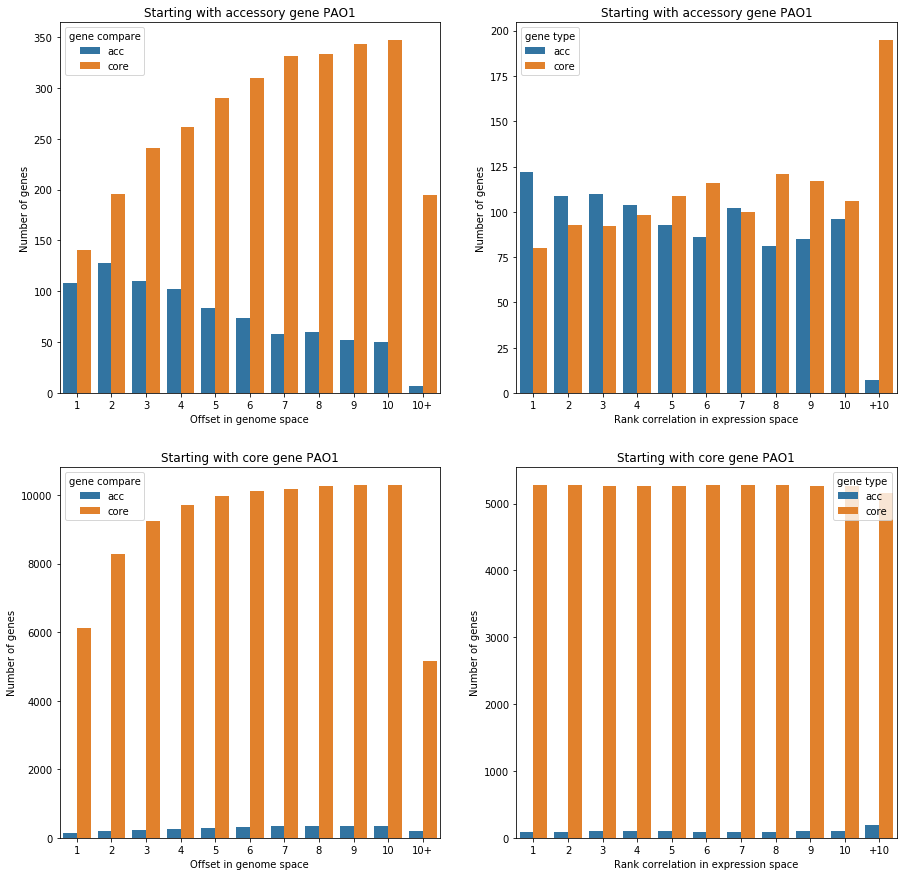

In [42]:
# Plot PAO1 trends
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(15, 15))

fig = sns.barplot(
    data=genome_dist_counts_pao1[genome_dist_counts_pao1["gene start"] == "acc"],
    x="offset",
    y="total",
    hue="gene compare",
    ax=axes[0][0],
)
fig.set_title("Starting with accessory gene PAO1")
fig.set_ylabel("Number of genes")
fig.set_xlabel("Offset in genome space")

fig = sns.barplot(
    data=genome_dist_counts_pao1[genome_dist_counts_pao1["gene start"] == "core"],
    x="offset",
    y="total",
    hue="gene compare",
    ax=axes[1][0],
)
fig.set_title("Starting with core gene PAO1")
fig.set_ylabel("Number of genes")
fig.set_xlabel("Offset in genome space")

fig = sns.barplot(
    data=expression_dist_counts_pao1_acc,
    x="offset",
    y="total",
    hue="gene type",
    ax=axes[0][1],
)
fig.set_title("Starting with accessory gene PAO1")
fig.set_ylabel("Number of genes")
fig.set_xlabel("Rank correlation in expression space")

fig = sns.barplot(
    data=expression_dist_counts_pao1_core,
    x="offset",
    y="total",
    hue="gene type",
    ax=axes[1][1],
)
fig.set_title("Starting with core gene PAO1")
fig.set_ylabel("Number of genes")
fig.set_xlabel("Rank correlation in expression space")

Text(0.5, 0, 'Rank correlation in expression space')

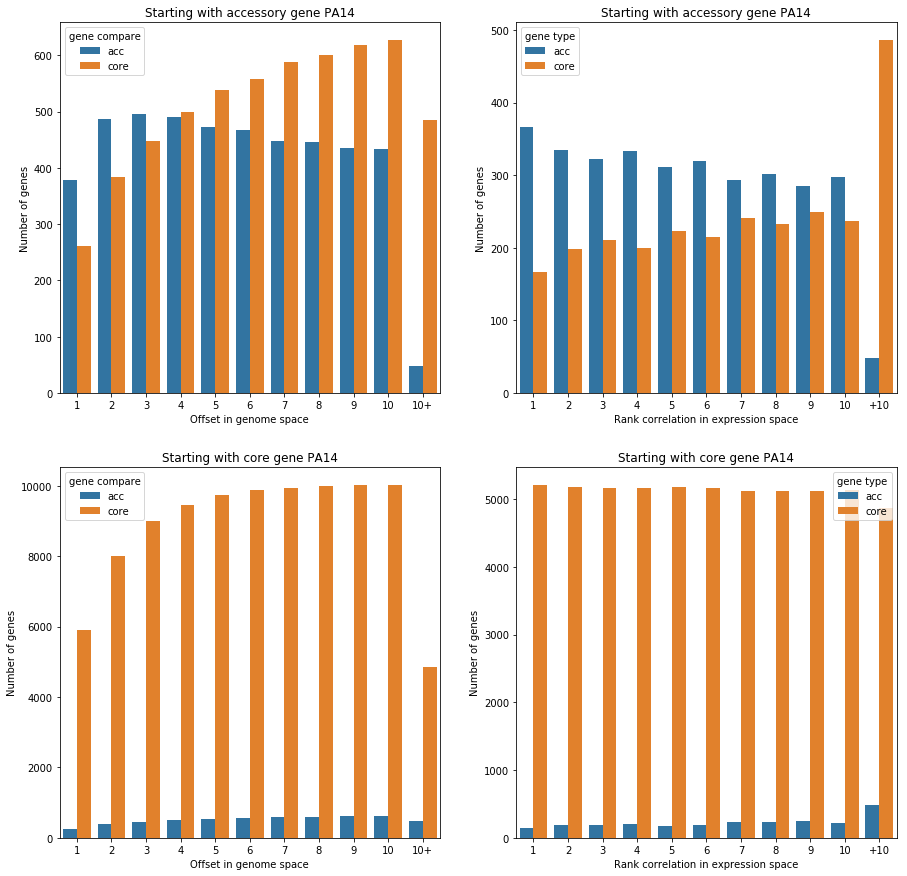

In [43]:
# Plot PA14 trends
fig2, axes2 = plt.subplots(ncols=2, nrows=2, figsize=(15, 15))

fig2 = sns.barplot(
    data=genome_dist_counts_pa14[genome_dist_counts_pa14["gene start"] == "acc"],
    x="offset",
    y="total",
    hue="gene compare",
    ax=axes2[0][0],
)
fig2.set_title("Starting with accessory gene PA14")
fig2.set_ylabel("Number of genes")
fig2.set_xlabel("Offset in genome space")

fig2 = sns.barplot(
    data=expression_dist_counts_pa14_acc,
    x="offset",
    y="total",
    hue="gene type",
    ax=axes2[0][1],
)
fig2.set_title("Starting with accessory gene PA14")
fig2.set_ylabel("Number of genes")
fig2.set_xlabel("Rank correlation in expression space")

fig2 = sns.barplot(
    data=genome_dist_counts_pa14[genome_dist_counts_pa14["gene start"] == "core"],
    x="offset",
    y="total",
    hue="gene compare",
    ax=axes2[1][0],
)
fig2.set_title("Starting with core gene PA14")
fig2.set_ylabel("Number of genes")
fig2.set_xlabel("Offset in genome space")

fig2 = sns.barplot(
    data=expression_dist_counts_pa14_core,
    x="offset",
    y="total",
    hue="gene type",
    ax=axes2[1][1],
)
fig2.set_title("Starting with core gene PA14")
fig2.set_ylabel("Number of genes")
fig2.set_xlabel("Rank correlation in expression space")

In [ ]:
# TO DO:
# Save figures using operons
# Save figures not using operons
# Save figure with rolling sum and operons
# Save figure with rolling sum not using operons

**Takeaway:**

In genome space:
* The closest non co-operonic neighbor to an accessory gene is a core gene for PAO1, but is an accessory gene for PA14
* Including co-operonic genes, accessory genes are clustered together on the genome (i.e. clustered with other accessory genes compared to core genes), which is known: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3008168/
* Starting with a core gene, at any distance you find core genes including and not including co-operonic genes.

In expression space:
* Accessory genes appear to be more highly co-expressed with other accessory genes. But this might be due to the accessory genes clustering together in the genome (i.e. they are found in the same operon).
* Core genes are highly correlated with other core genes, again, this may be due to the fact that there are so many more core genes.

* Accessory genes seem to have a strong relationship with other accessory genes in PA14, but not PAO1. Why?

Some things to note about this analysis that may need to be updated:
* There are some operons that have multiple annotations, which one should we choose? Should we drop these from the analysis? Should we curate these to determine which ones?
* When we sorted the gene ids, we found that PAO1 incremented by 1 and PA14 incremented by 10 or 20, are we missing genes for PA14? How much will this change our genome dist analysis?